In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from theano import shared
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

## Simple linear regression

In [3]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

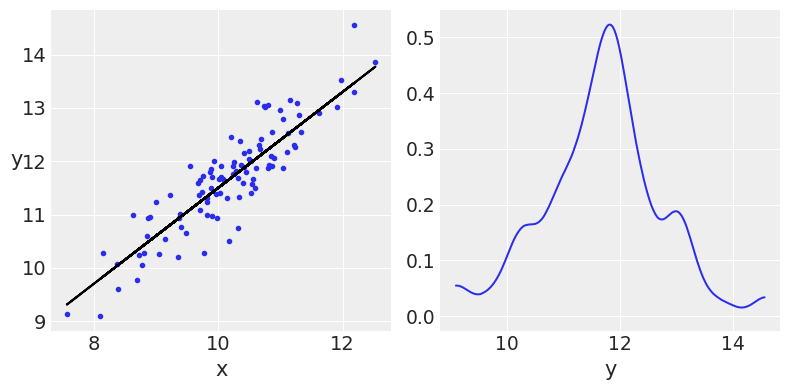

In [4]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()
plt.savefig('B11197_03_02.png', dpi=300)

In [5]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:11<00:00, 523.83draws/s]


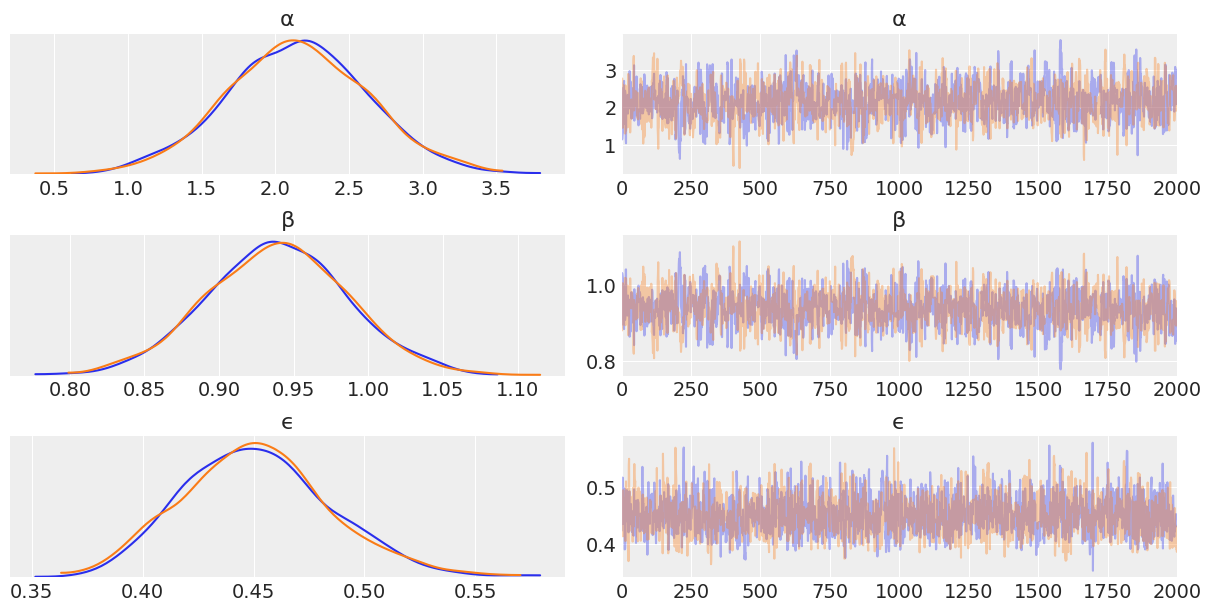

In [6]:
az.plot_trace(trace_g, var_names=['α', 'β', 'ϵ'])
plt.savefig('B11197_03_03.png', dpi=300)

### Modyfing the data before running the models

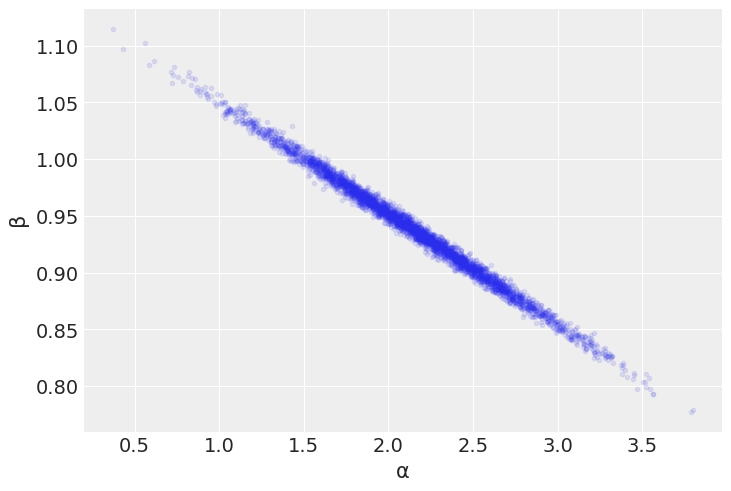

In [7]:
az.plot_pair(trace_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})
plt.savefig('B11197_03_04.png', dpi=300)

### interpreting the posterior

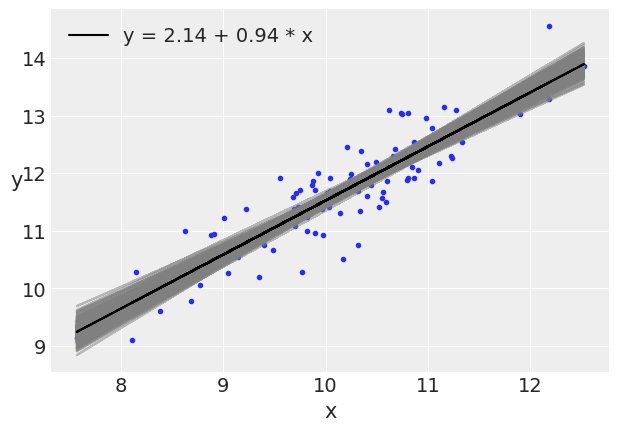

In [8]:
plt.plot(x, y, 'C0.')

alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()

draws = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws]
         * x[:, np.newaxis], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()
plt.savefig('B11197_03_05.png', dpi=300)

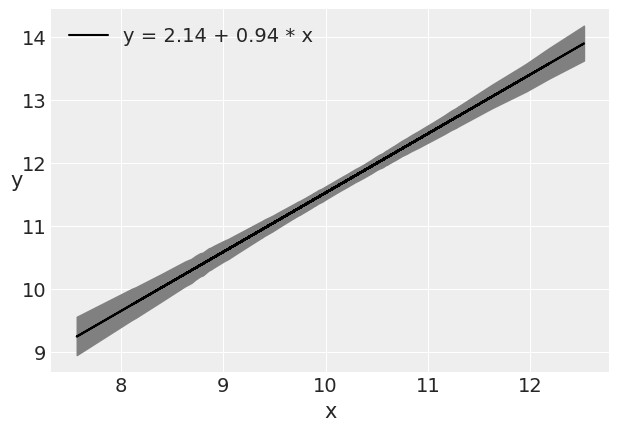

In [9]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

idx = np.argsort(x)
sig = pm.hpd(trace_g['μ'], alpha=.02)[idx]
plt.fill_between(x[idx], sig[:, 0], sig[:, 1], color='gray')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()
plt.savefig('B11197_03_06.png', dpi=300)

In [10]:
ppc = pm.sample_posterior_predictive(trace_g, samples=2000, model=model_g)

100%|██████████| 2000/2000 [00:01<00:00, 1582.51it/s]


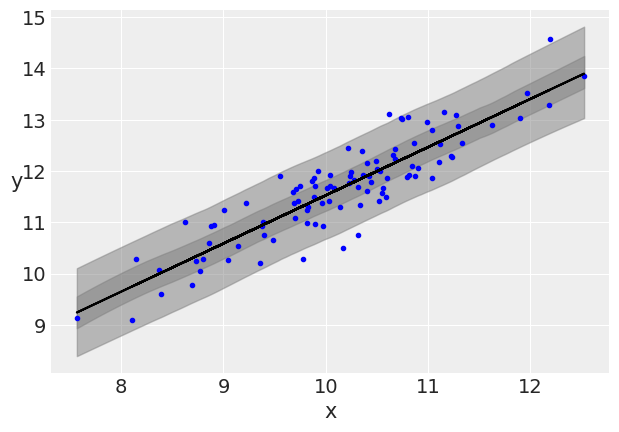

In [11]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='gray')
az.plot_hpd(x, ppc['y_pred'], color='gray')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_07.png', dpi=300)

In [12]:
az.r2_score(y, ppc['y_pred'])

r2        0.785711
r2_std    0.005941
dtype: float64

### The multivariate normal distribution 
Actually the bivariate

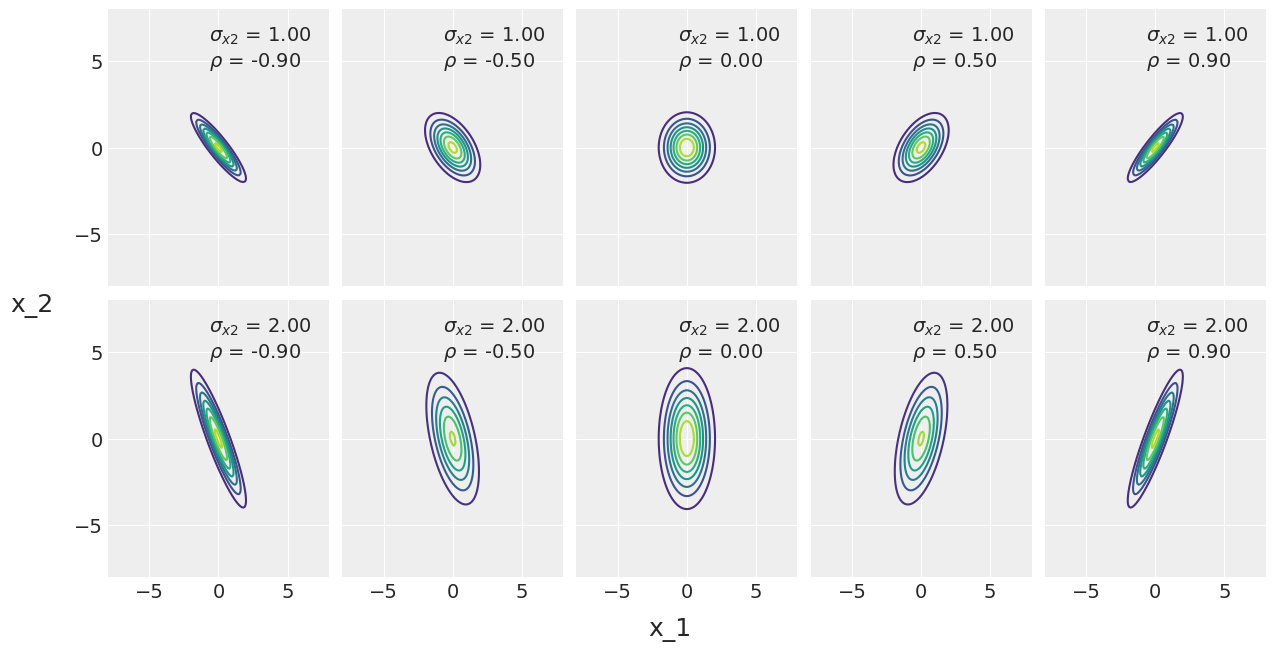

In [13]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.90, -0.5, 0, 0.5, 0.90]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k
pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos),
                     sharex=True, sharey=True, figsize=(12, 6),
                     constrained_layout=True)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
               [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i, j].contour(k, l, rv.pdf(pos))
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0,
                      label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
        ax[i, j].legend()
f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)
plt.savefig('B11197_03_08.png', dpi=300)

In [14]:
data = np.stack((x, y)).T
with pm.Model() as pearson_model:

    μ = pm.Normal('μ', mu=data.mean(0), sd=10, shape=2)

    σ_1 = pm.HalfNormal('σ_1', 10)
    σ_2 = pm.HalfNormal('σ_2', 10)
    ρ = pm.Uniform('ρ', -1., 1.)
    r2 = pm.Deterministic('r2', ρ**2)

    cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ],
                         [σ_1*σ_2*ρ, σ_2**2]))

    y_pred = pm.MvNormal('y_pred', mu=μ, cov=cov, observed=data)

    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ρ, σ_2, σ_1, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 313.56draws/s]


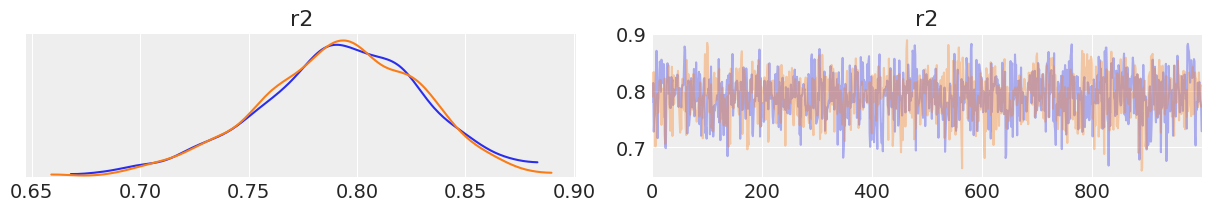

In [15]:
az.plot_trace(trace_p, var_names=['r2'])
plt.savefig('B11197_03_9.png', dpi=300)

In [16]:
az.summary(trace_p, var_names=['r2'])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
r2,0.79,0.04,0.0,0.72,0.86,1197.0,1.0


## Robust linear regression

In [17]:
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

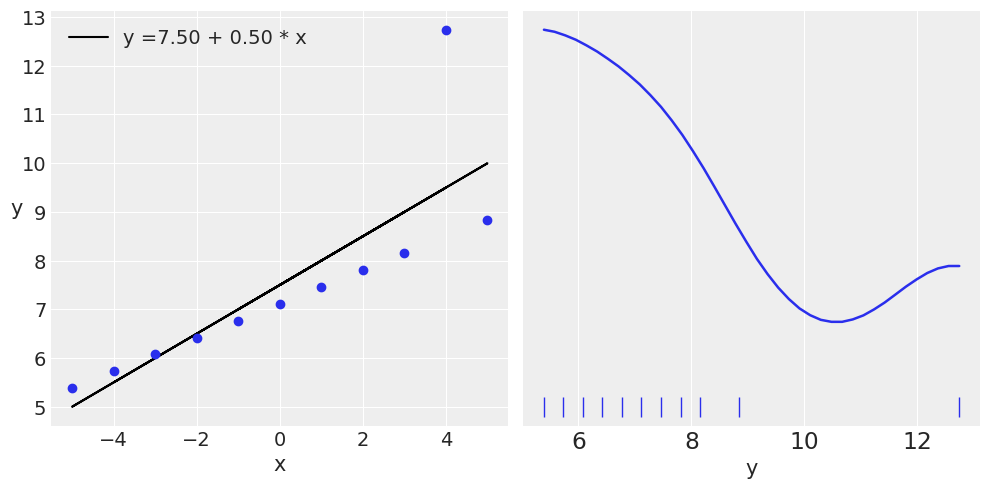

In [18]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()
plt.savefig('B11197_03_10.png', dpi=300)

In [19]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν, observed=y_3)

    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_, ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 839.52draws/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ba70916d8>,
      dtype=object)

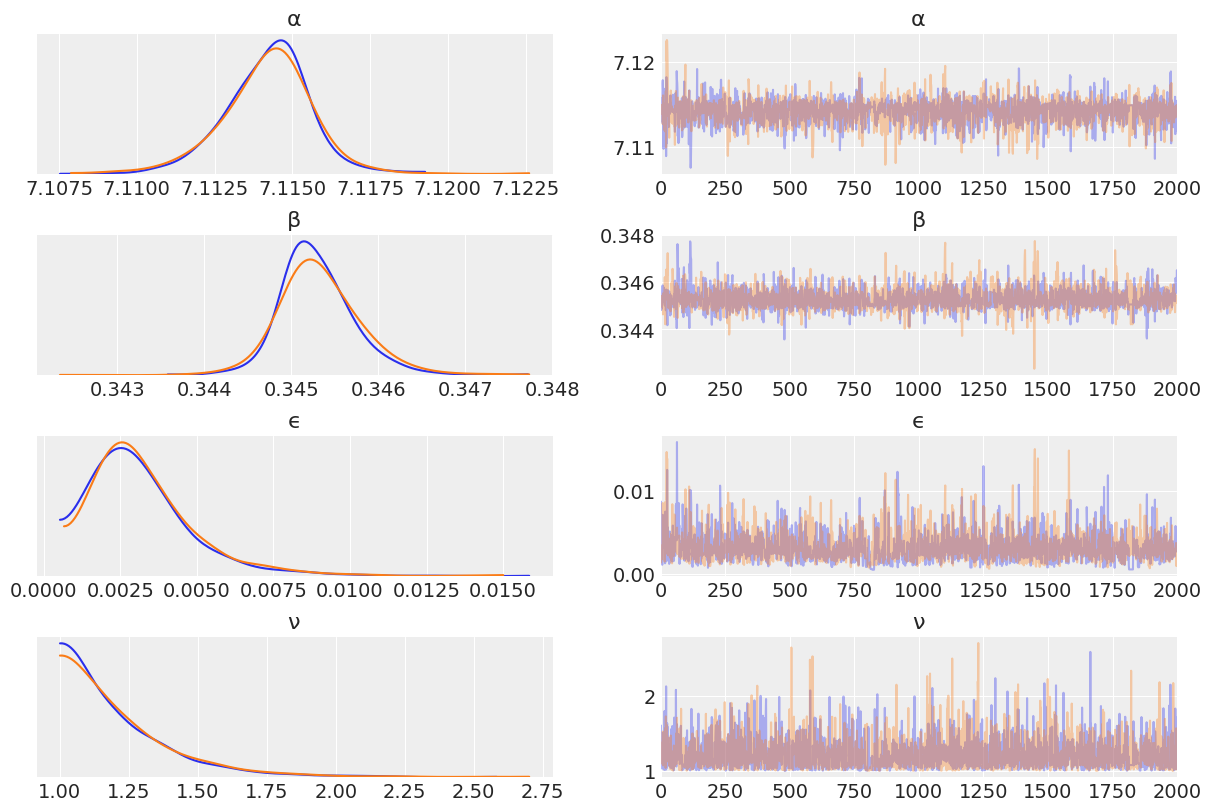

In [20]:
varnames = ['α', 'β', 'ϵ', 'ν']
az.plot_trace(trace_t, var_names=varnames);

In [21]:
az.summary(trace_t, var_names=varnames)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,7.11,0.00,0.0,7.11,7.12,2216.0,1.0
β,0.35,0.00,0.0,0.34,0.35,2156.0,1.0
ϵ,0.00,0.00,0.0,0.00,0.01,1257.0,1.0
ν,1.21,0.21,0.0,1.00,1.58,3138.0,1.0


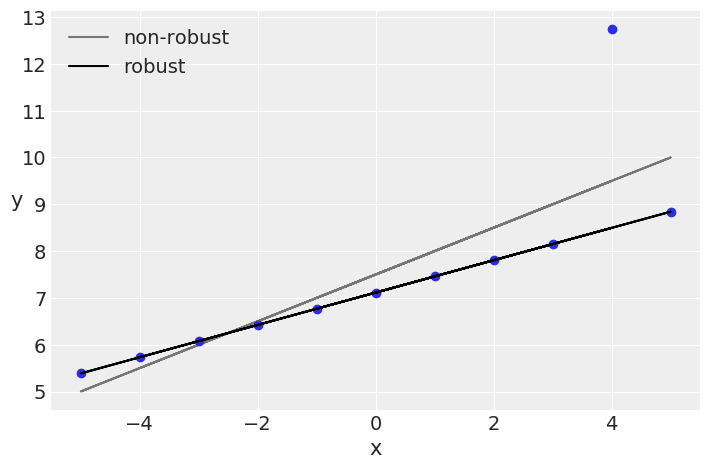

In [22]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

plt.savefig('B11197_03_11.png', dpi=300)

In [24]:
ppc = pm.sample_posterior_predictive(trace_t, samples=200, model=model_t, random_seed=2)

100%|██████████| 200/200 [00:00<00:00, 1016.70it/s]


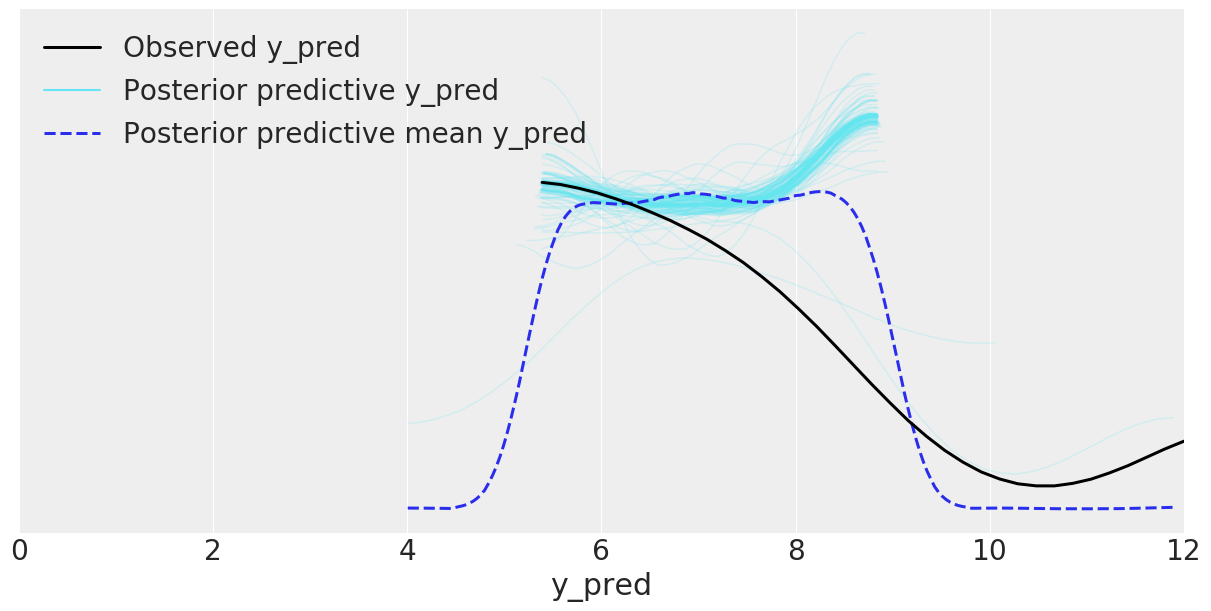

In [26]:
data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
plt.xlim(0, 12)
plt.savefig('B11197_03_12.png', dpi=300)

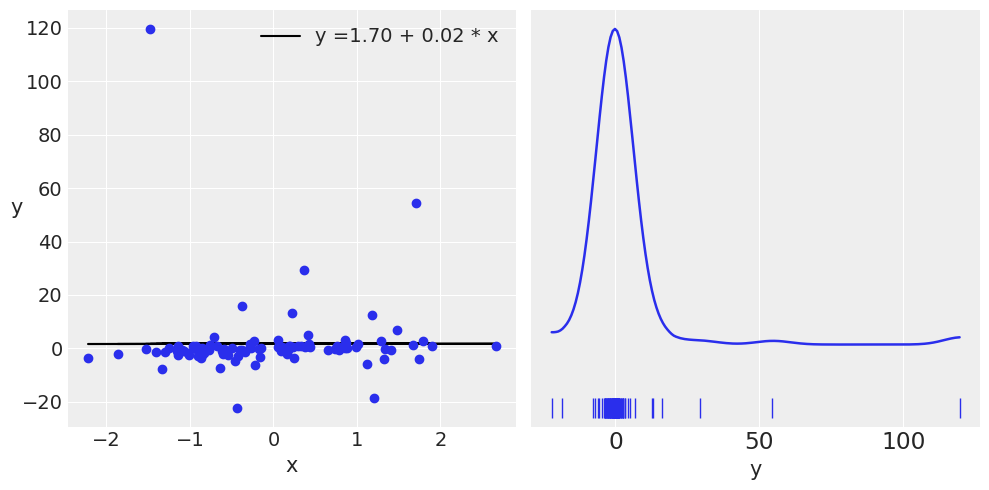

In [27]:
# Exercise X
np.random.seed(314)
x_4 = np.random.normal(size=100)
# experiments with different values of df
y_4 = x_4 + np.random.standard_t(df=1, size=100)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_4, y_4)[:2]
ax[0].plot(x_4, (alpha_c + beta_c * x_4), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_4, y_4, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_4, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()

In [28]:
# exercise x
with pm.Model() as model_t2:
    α = pm.Normal('α', mu=0, sd=100)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    #ν = pm.Gamma('ν', mu=20, sd=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sd=ϵ, nu=ν, observed=y_4)
    trace_t2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1542.24draws/s]


## Hierarchical linear regression

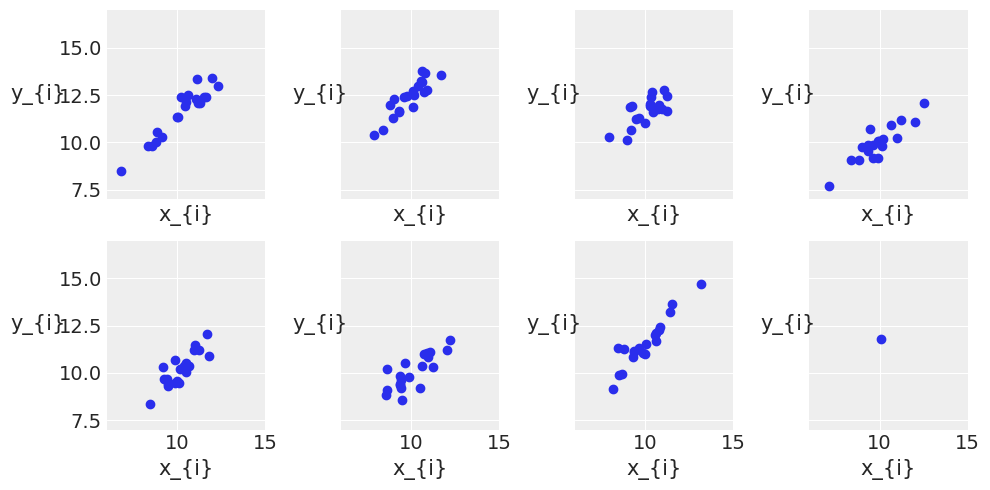

In [29]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel('x_{i}')
    ax[i].set_ylabel('y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B11197_03_13.png', dpi=300)

In [30]:
x_centered = x_m - x_m.mean()

In [31]:
with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())

    trace_up = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_tmp]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:06<00:00, 814.20draws/s] 


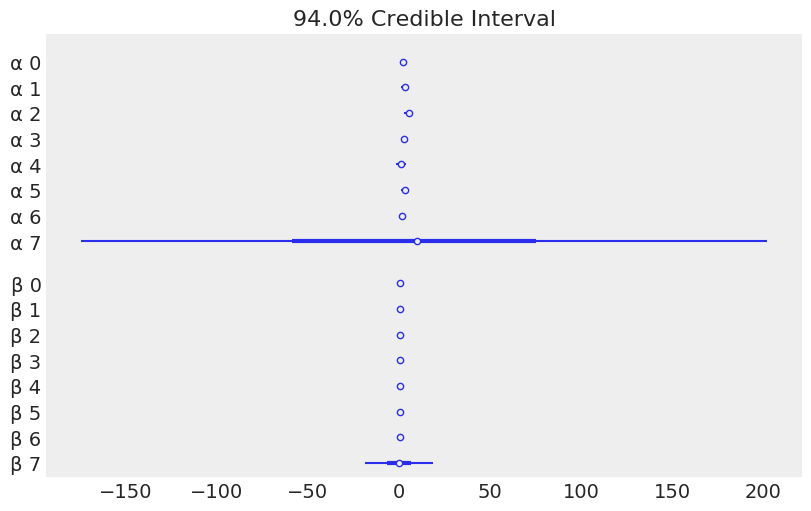

In [32]:
az.plot_forest(trace_up, var_names=['α', 'β'], figsize=(8, 5), combined=True)
plt.savefig('B11197_03_14.png', dpi=300)

In [33]:
#az.summary(trace_up, var_names=varnames)


 <img src='B11197_03_15.png' width="700">

In [34]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    trace_hm = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 476.82draws/s]
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7127172754270983, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


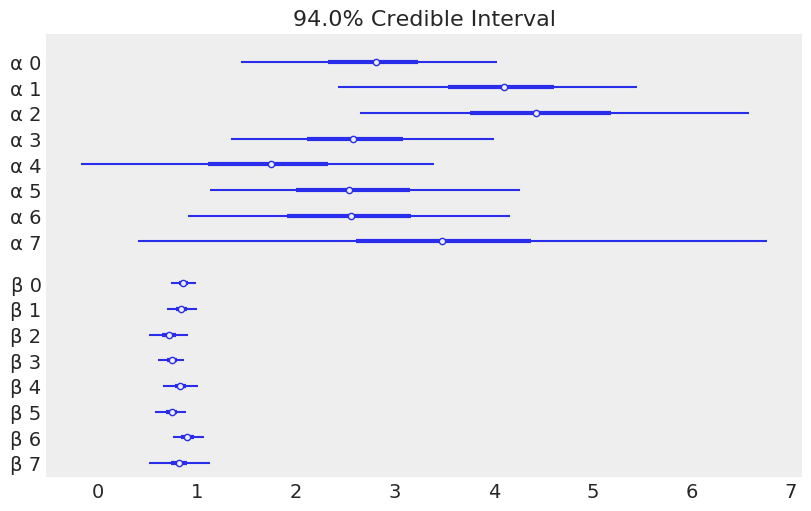

In [35]:
az.plot_forest(trace_hm, var_names=['α', 'β'], figsize=(8, 5), combined=True)
plt.savefig('B11197_03_16.png', dpi=300)

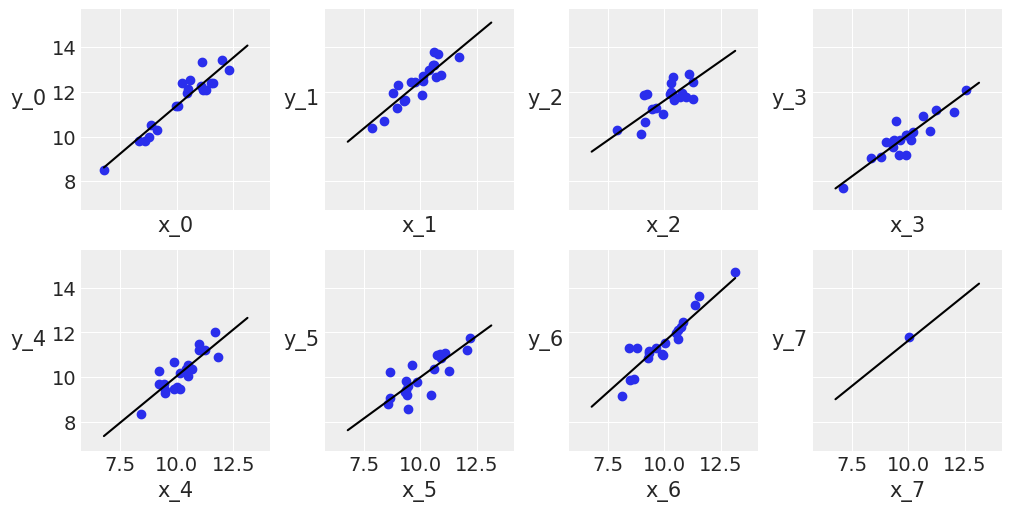

In [36]:
# add uncertainty
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.savefig('B11197_03_17.png', dpi=300)

## Polynomial regression

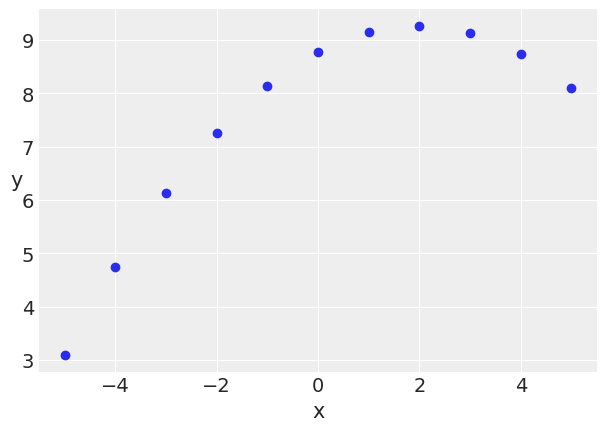

In [37]:
#ans = pd.read_csv('anscombe.csv')
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()
#y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_18.png', dpi=300)

In [38]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    mu = α + β1 * x_2 + β2 * x_2**2

    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_2)

    trace_poly = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 858.40draws/s] 
The acceptance probability does not match the target. It is 0.9035350551662957, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ba46f2240>,
      dtype=object)

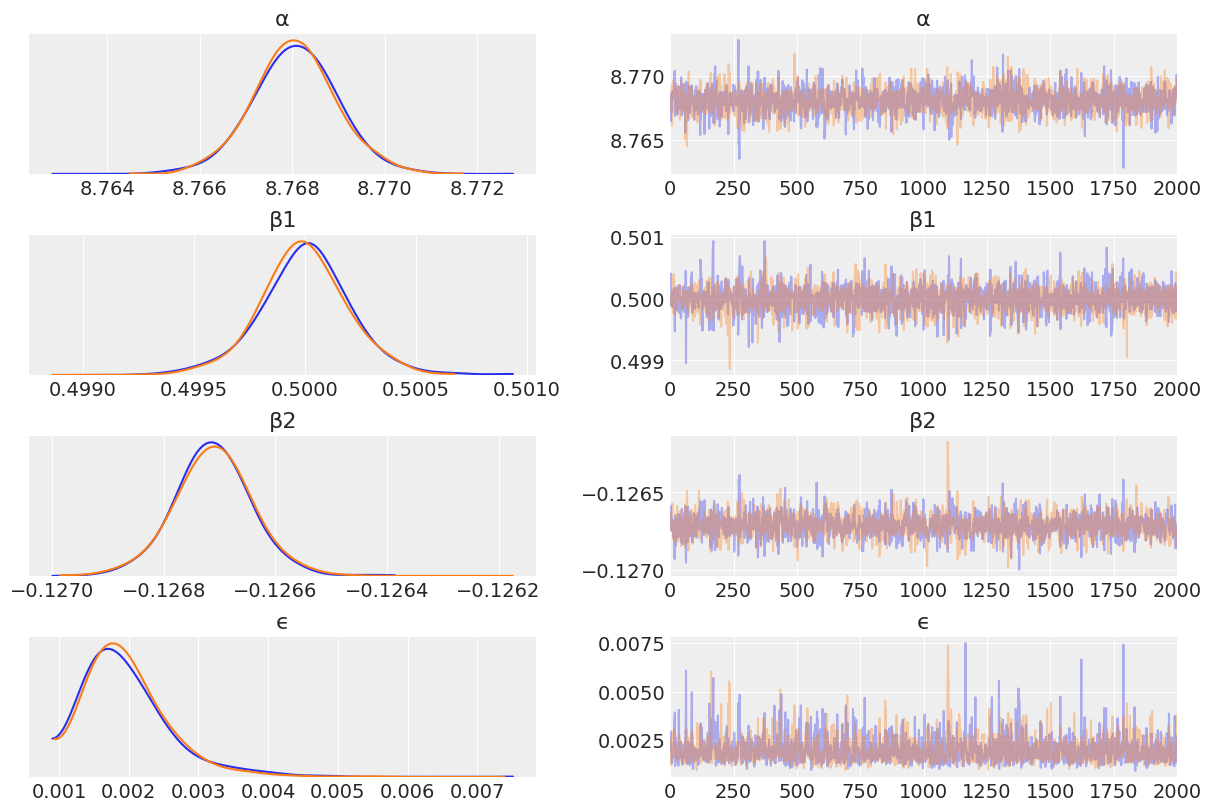

In [39]:
az.plot_trace(trace_poly)
#plt.savefig('B04958_04_22.png', dpi=300, )

In [40]:
az.summary(trace_poly)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,8.77,0.0,0.0,8.77,8.77,1939.0,1.0
β1,0.50,0.0,0.0,0.50,0.50,2728.0,1.0
β2,-0.13,0.0,0.0,-0.13,-0.13,1820.0,1.0
ϵ,0.00,0.0,0.0,0.00,0.00,1606.0,1.0


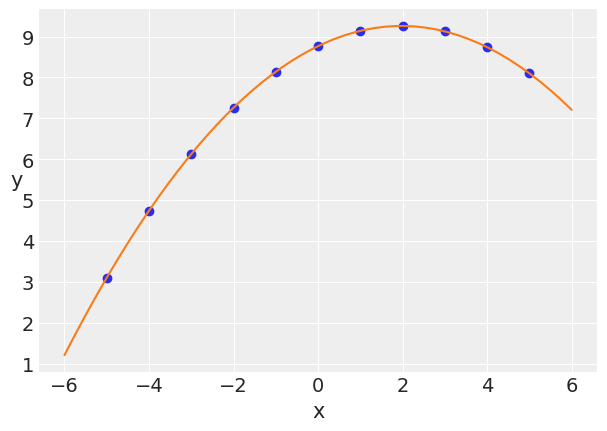

In [41]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['α'].mean() + trace_poly['β1'].mean() * \
    x_p + trace_poly['β2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')
plt.savefig('B11197_03_19.png', dpi=300)

## Multiple Linear regression

In [42]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

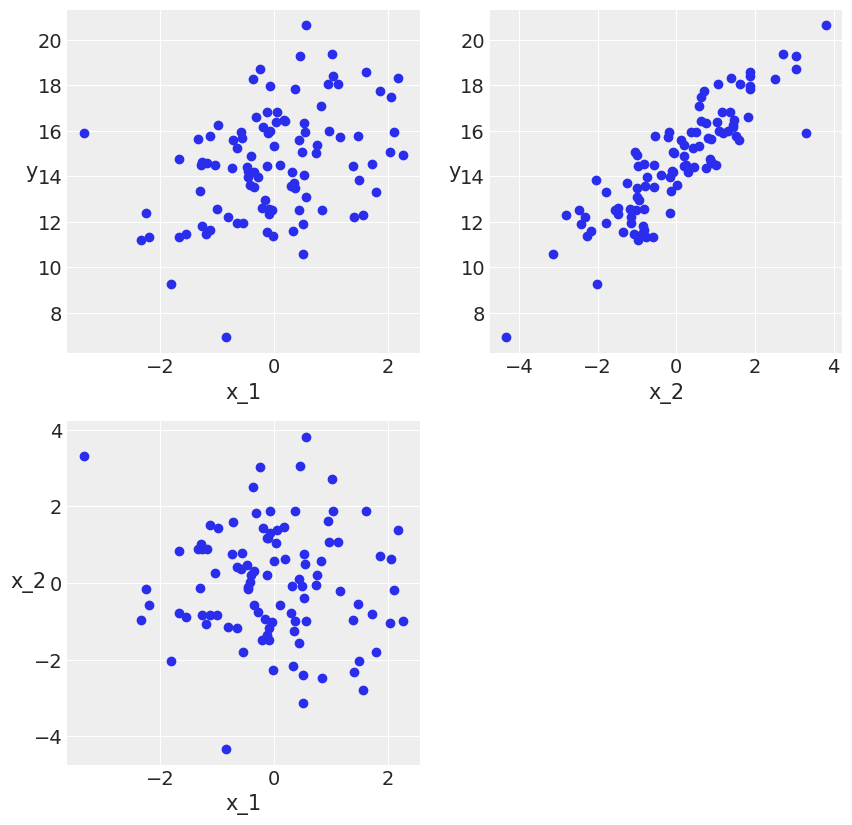

In [43]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)


scatter_plot(X_centered, y)
plt.savefig('B11197_03_20.png', dpi=300)

In [44]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α_tmp + pm.math.dot(X_centered, β)

    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α_tmp]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1270.62draws/s]


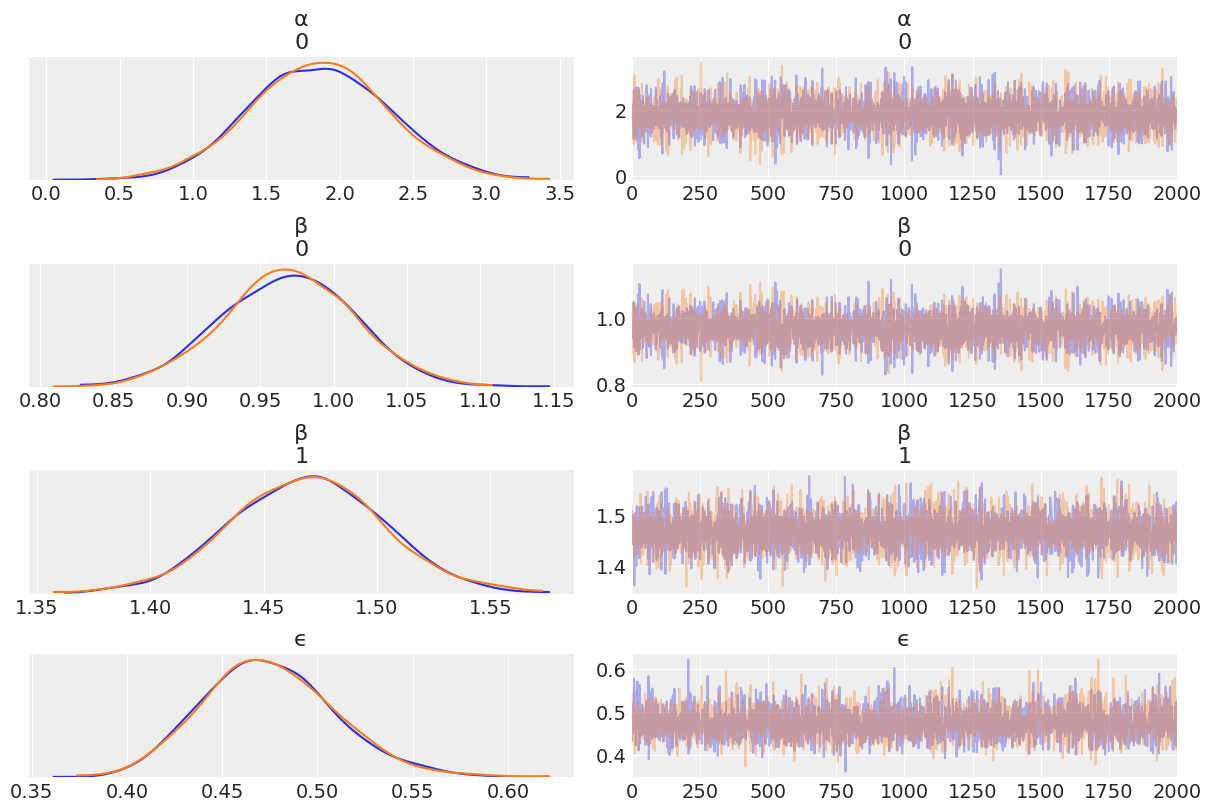

In [45]:
varnames = ['α', 'β', 'ϵ']
az.plot_trace(trace_mlr, var_names=varnames);

In [46]:
az.summary(trace_mlr, var_names=varnames)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α[0],1.86,0.46,0.0,0.95,2.69,5251.0,1.0
β[0],0.97,0.04,0.0,0.89,1.05,5467.0,1.0
β[1],1.47,0.03,0.0,1.40,1.53,5464.0,1.0
ϵ,0.47,0.03,0.0,0.41,0.54,4159.0,1.0


## Confounding variables and redundant variables

In [47]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

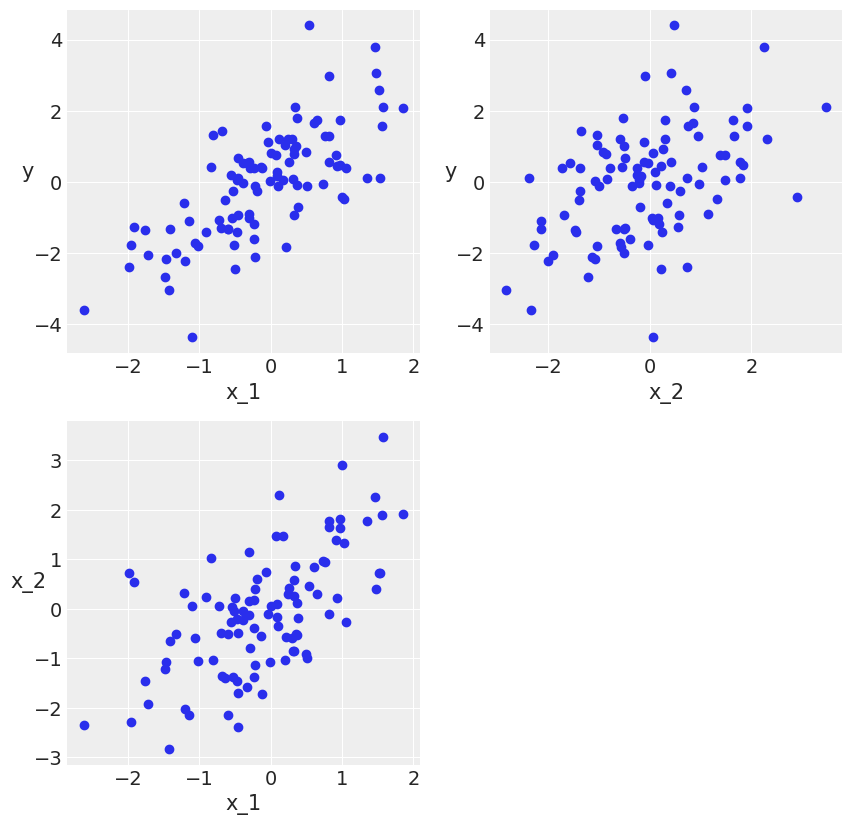

In [48]:
scatter_plot(X, y)
plt.savefig('B11197_03_21.png', dpi=300)

In [49]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1x2 = pm.sample(2000)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1 = pm.sample(2000)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1523.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β1, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 1912.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1516.17draws/s]


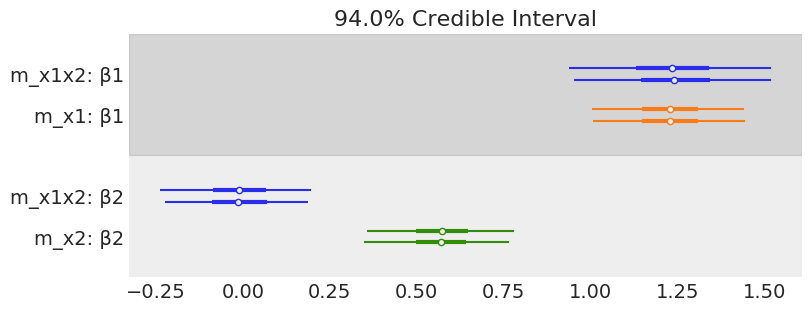

In [50]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2], model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'], combined=False, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_22.png', dpi=300)

In [51]:
# just repeating the code from a couple of cells before, but with a lower value of `scale`.
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

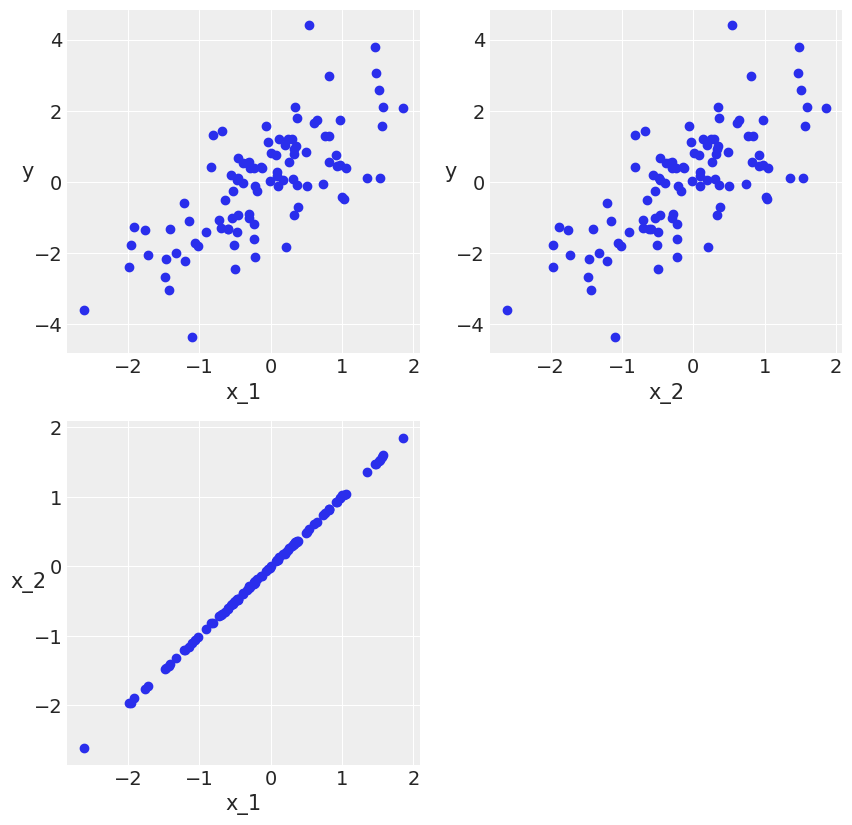

In [52]:
scatter_plot(X, y)
plt.savefig('B11197_03_23.png', dpi=300)

In [53]:
with pm.Model() as model_red:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + pm.math.dot(X, β)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_red = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:01<00:00, 81.05draws/s] 
The acceptance probability does not match the target. It is 0.879378320954778, but should be close to 0.8. Try to increase the number of tuning steps.


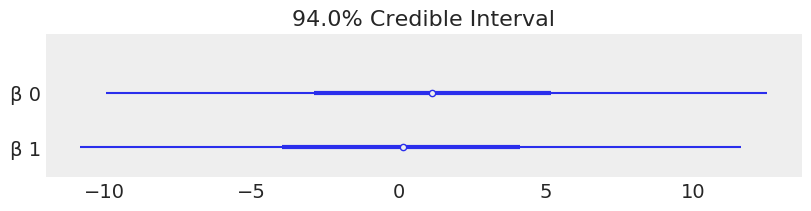

In [54]:
az.plot_forest(trace_red, var_names=['β'], combined=True, figsize=(8, 2))
plt.savefig('B11197_03_24.png', dpi=300)

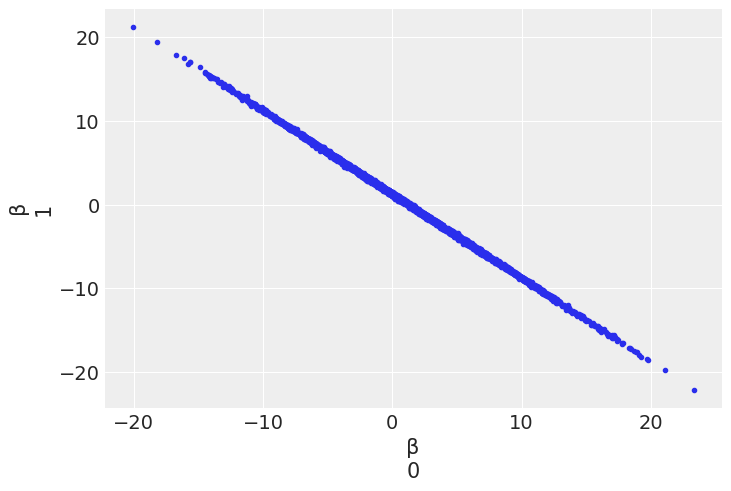

In [55]:
az.plot_pair(trace_red, var_names=['β'])
plt.savefig('B11197_03_25.png', dpi=300)

## Masking effect variables

In [56]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T

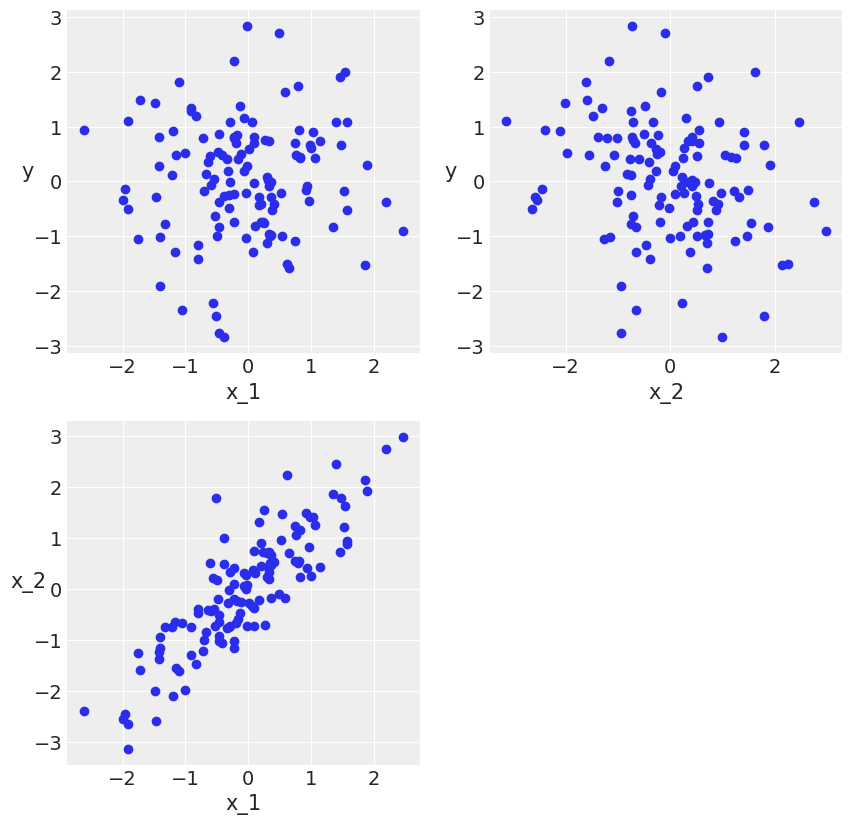

In [57]:
scatter_plot(X, y)
plt.savefig('B11197_03_26.png', dpi=300, figsize=(5.5, 5.5))

In [58]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1x2 = pm.sample(1000)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1 = pm.sample(1000)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 919.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β1, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1796.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1293.61draws/s]


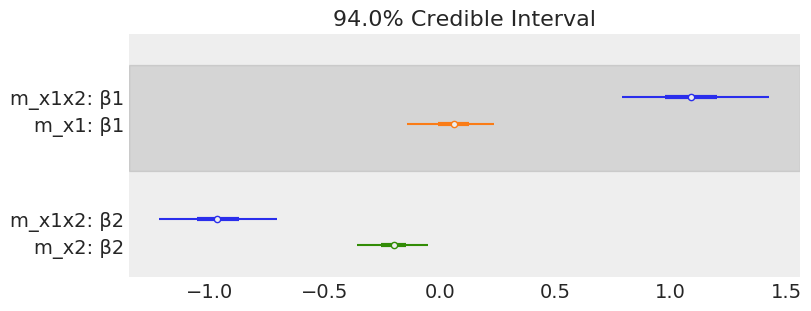

In [59]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2], model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'], combined=True, colors='cycle',
               figsize=(8, 3))
plt.savefig('B11197_03_27.png', dpi=300, bbox_inches='tight')

## Variable variance

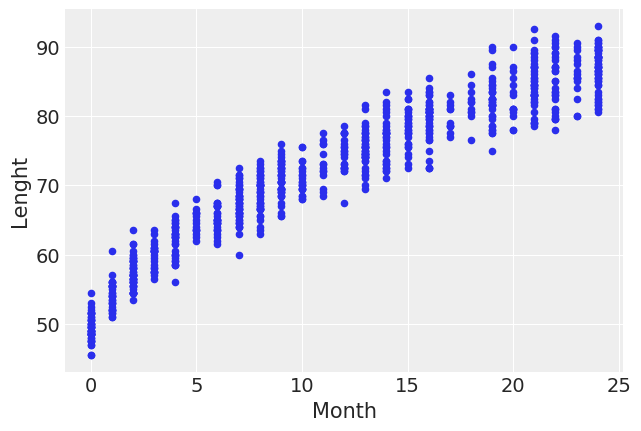

In [60]:
data = pd.read_csv('../data/babies.csv')
data.plot.scatter('Month', 'Lenght')
plt.savefig('B11197_03_28.png', dpi=300)

In [61]:
with pm.Model() as model_vv:
    α = pm.Normal('α', sd=10)
    β = pm.Normal('β', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)

    x_shared = shared(data.Month.values * 1.)

    μ = pm.Deterministic('μ', α + β * x_shared**0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=data.Lenght)

    trace_vv = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [δ, γ, β, α]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 456.24draws/s]


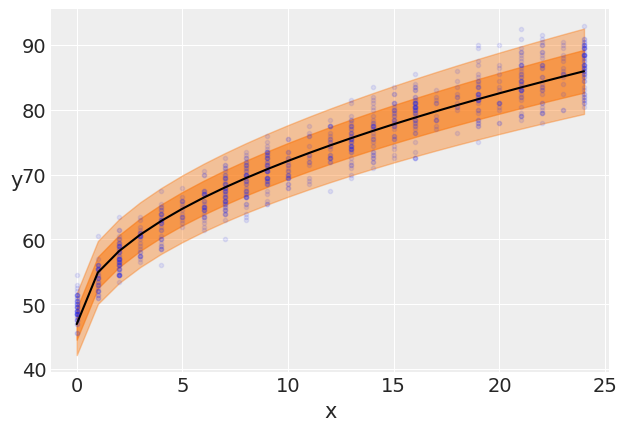

In [62]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)

μ_m = trace_vv['μ'].mean(0)
ϵ_m = trace_vv['ϵ'].mean(0)

plt.plot(data.Month, μ_m, c='k')
plt.fill_between(data.Month, μ_m + 1 * ϵ_m, μ_m -
                 1 * ϵ_m, alpha=0.6, color='C1')
plt.fill_between(data.Month, μ_m + 2 * ϵ_m, μ_m -
                 2 * ϵ_m, alpha=0.4, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_29.png', dpi=300)

In [63]:
x_shared.set_value([0.5])
ppc = pm.sample_posterior_predictive(trace_vv, 2000, model=model_vv)
y_ppc = ppc['y_pred'][:, 0]

100%|██████████| 2000/2000 [00:02<00:00, 942.68it/s]


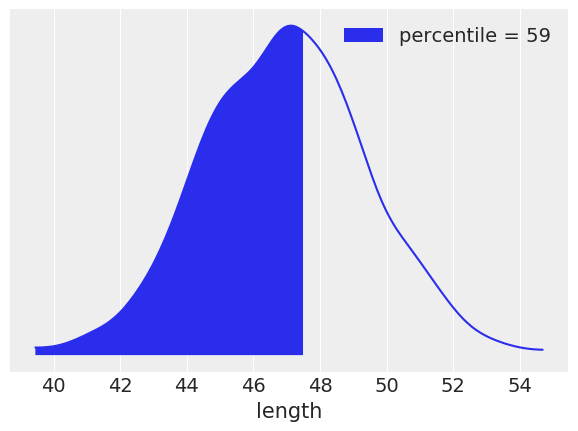

In [64]:
ref = 47.5
density, l, u = az._fast_kde(y_ppc)
x_ = np.linspace(l, u, 200)
plt.plot(x_, density)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], density[x_ < ref],
                 label='percentile = {:2d}'.format(percentile))
plt.xlabel('length')
plt.yticks([])
plt.legend()
plt.savefig('B11197_03_30.png', dpi=300)